In [11]:
data = """
timestamp, event, value
2023-10-19 10:00:05, create, 38
2023-10-19 10:01:05, read, 24
2023-10-19 10:02:05, update, 56
2023-10-19 10:03:05, delete, 81
2023-10-19 10:04:05, update, 2
2023-10-19 10:05:05, create, 7
2023-10-19 10:06:05, delete, 11
2023-10-19 10:07:05, read, 19
2023-10-19 10:08:05, read, 31
2023-10-19 10:09:05, update, 45
"""

with open("activity.csv", "w") as file:
    file.write(data)

In [12]:
!pip install apache-beam[interactive]

In [13]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.io import ReadFromText, WriteToText
from apache_beam.transforms.window import FixedWindows
from apache_beam.transforms import WindowInto
from apache_beam.transforms.trigger import AfterCount, Repeatedly

In [15]:
class ExtractActivityValueFn(beam.DoFn):
   def process(self, element):
        parts = element.split(',')
        if len(parts) == 3:
            _, activity, value = parts
            yield (activity.strip(), int(value.strip()))

In [16]:
class ExtractAndSumValues(beam.PTransform):
    def expand(self, pcoll):
        return (
            pcoll
            | 'ExtractActivityValue' >> beam.ParDo(ExtractActivityValueFn())
            | 'SumValues' >> beam.CombinePerKey(sum)
        )

In [17]:
# Define the pipeline
def run_pipeline():
    # Set up the pipeline options
    options = PipelineOptions()
    p = beam.Pipeline(options=options)

    # Read from the input file
    activities = (
        p
        | 'ReadFromFile' >> ReadFromText('activity.csv')
        | 'SkipHeader' >> beam.Filter(lambda x: not x.startswith('timestamp'))
        | 'WindowInto1MinWithTrigger' >> beam.WindowInto(FixedWindows(60), trigger=Repeatedly(AfterCount(2)), accumulation_mode=beam.transforms.trigger.AccumulationMode.DISCARDING)

    )

    # Apply the composite transform
    processed_activities = activities | 'ProcessActivities' >> ExtractAndSumValues()

    # Write to the output file
    processed_activities | 'WriteToResults' >> WriteToText('results.txt')

    # Run the pipeline
    result = p.run()
    result.wait_until_finish()

In [18]:
# Execute the pipeline
if __name__ == '__main__':
    run_pipeline()

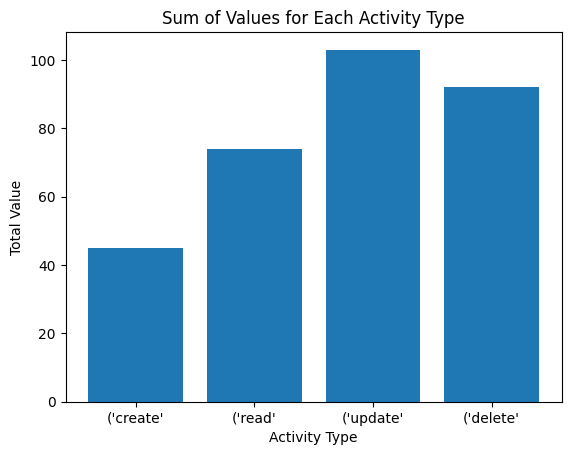

In [19]:
import matplotlib.pyplot as plt
import re

# Read the results from the output file
with open("/content/results.txt-00000-of-00001", "r") as file:
    lines = file.readlines()

# Extract activities and their sums
activities, values = [], []
for line in lines:
    event, value = line.strip().split(',')
    # Remove any non-digit characters from value
    cleaned_value = re.sub(r'\D', '', value)
    activities.append(event)
    values.append(int(cleaned_value))

# Plot
plt.bar(activities, values)
plt.xlabel('Activity Type')
plt.ylabel('Total Value')
plt.title('Sum of Values for Each Activity Type')
plt.show()

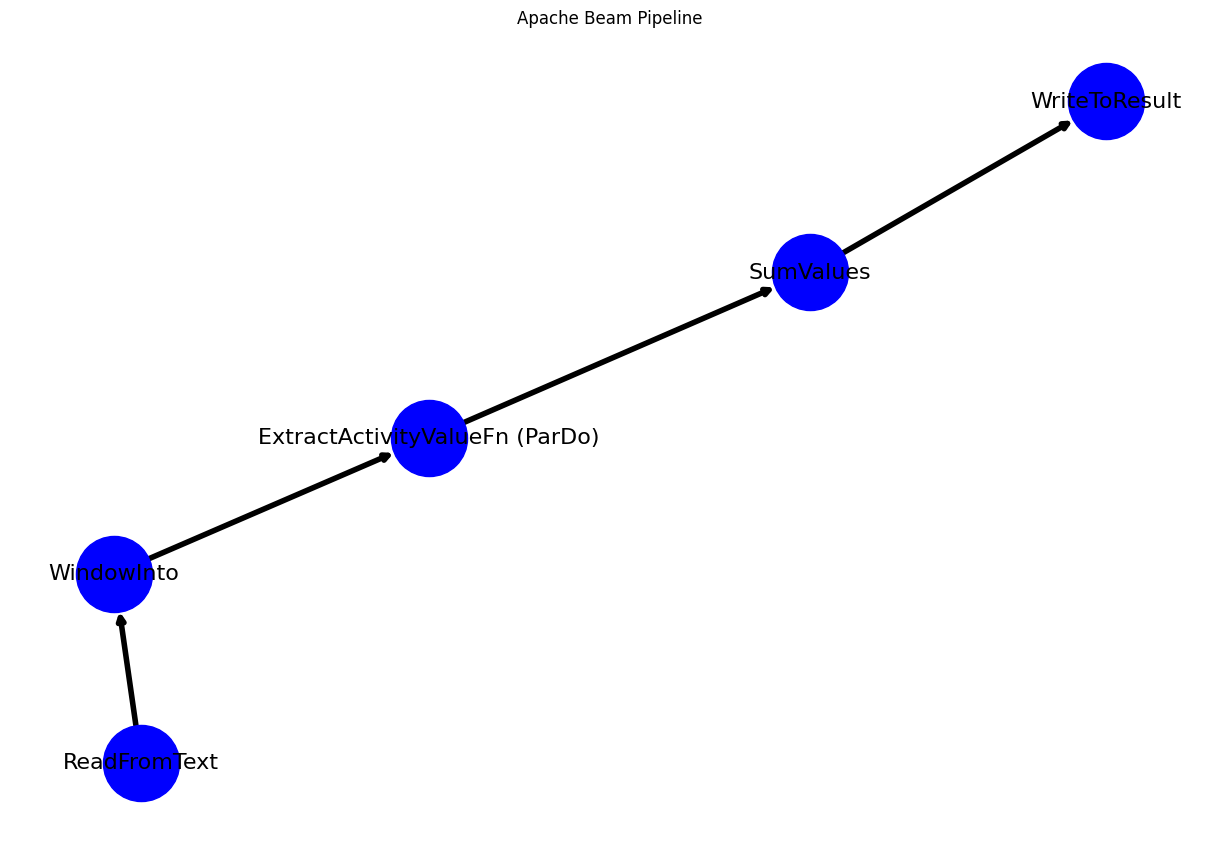

In [21]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Nodes represent stages or transforms in the pipeline
nodes = ["ReadFromText", "WindowInto", "ExtractActivityValueFn (ParDo)", "SumValues", "WriteToResult"]
G.add_nodes_from(nodes)

# Edges represent data flow
edges = [("ReadFromText", "WindowInto"),
         ("WindowInto", "ExtractActivityValueFn (ParDo)"),
         ("ExtractActivityValueFn (ParDo)", "SumValues"),
         ("SumValues", "WriteToResult")]
G.add_edges_from(edges)

# Draw the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="blue", font_size=16, width=4, edge_color="black")
plt.title("Apache Beam Pipeline")
plt.show()